
This notebook prepares the subject-level mean distances and between-subject distances for 1443 chowell 2018 kept subjects

This is only the first step of the processing

There is another step of processing to add the values from set based approach


### mean distance between HLA alleles for each subject:

    depth on Zheng 2021 positive TCRs, cor (mean_DePTH_cor)
    
    glazer on Zheng 2021 positive TCRs, cor (mean_CLAIRE_cor)
    
    blosum62-based distance (mean_AA)
    
the items below are left for the next notebook:
    
    depth on Zheng 2021 positive TCRs, set
    
    glazer on Zheng 2021 positive TCRs, set
    
    depth on Zheng 2021 positive TCRs, breadth
    
    glazer on Zheng 2021 positive TCRs, breadth

### optimal transport distance among subjects:

    depth on Zheng 2021 pos TCRs, cor (dist_DePTH_cor)
    
    glazer on Zheng 2021 pos TCRs, cor (dist_CLAIRE_cor)
    
    blosum62 based distance (dist_AA)
    
the items below are left for the next notebook:
    
    depth on Zheng 2021 pos TCRs, set
    
    glazer on Zheng 2021 pos TCRs, set

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
from collections import Counter

import ot
import ot.plot

import matplotlib.pyplot as plt
import math

In [2]:
# load the info of subjects with HLA-I alleles under our consideration
df_2018_kept = pd.read_csv("../results/st6_chowell_2018_kept_hla_match_replace.csv", header=0)
df_2018_kept[:6]

,ID,age,age_group,os_months,os_event,mutcnt,gender,drug_class,cancer_type,stage_m,stage,reference,hla_class_i_alleles,homozygous,hla_class_i_alleles_replace
0,CR0095,74.0,>71,67.936885,0.0,9.400000,M,CTLA-4,Melanoma,M1b,Stage 4,Snyder et al. 2014,"A0201,A3101,B3502,B3906,C0702,C0401",0.0,"A0201,A3101,B3502,B3906,C0702,C0401"
1,CR04885,49.0,31-50,25.617525,0.0,70.066667,F,CTLA-4,Melanoma,M0,Stage 3,Snyder et al. 2014,"A0201,A3201,B0702,B1801,C0701,C0702",0.0,"A0201,A3201,B0702,B1801,C0701,C0702"
2,CR06670,79.0,>71,44.430394,1.0,19.666667,F,CTLA-4,Melanoma,M0,Stage 3,Snyder et al. 2014,"A2402,A2601,B1801,B4403,C1601,C1203",0.0,"A2402,A2601,B1801,B4403,C1601,C1203"
3,CR1509,54.0,50-60,53.888915,0.0,17.966667,F,CTLA-4,Melanoma,M1c,Stage 4,Snyder et al. 2014,"A3301,A2601,B3801,B3501,C1203,C0401",0.0,"A3301,A2601,B3801,B3501,C1203,C0401"
4,CR22640,71.0,>71,51.235049,0.0,11.133333,M,CTLA-4,Melanoma,M1c,Stage 4,Snyder et al. 2014,"A0301,A0201,B4101,B5001,C1701,C0602",0.0,"A0301,A0201,B4101,B5001,C1701,C0602"
5,CR3665,70.0,61-70,31.879338,0.0,4.700000,M,CTLA-4,Melanoma,M1b,Stage 4,Snyder et al. 2014,"A0205,A6801,B1402,B1801,C0701,C0802",0.0,"A0205,A6801,B1402,B1801,C0701,C0802"


In [3]:
Counter(df_2018_kept.reference)

Counter({'Snyder et al. 2014': 62,
         'Van Allen et al. 2015': 98,
         'Riaz et al. 2017': 68,
         'Hugo et al. 2016': 37,
         'Rizvi et al. 2015': 34,
         'Rizvi_CUMC': 58,
         'MSK-IMPACT': 1086})

In [4]:
df_2018_kept.isna().sum()

ID                                0
age                            1086
age_group                         0
os_months                         0
os_event                          0
mutcnt                           58
gender                         1086
drug_class                        0
cancer_type                       2
stage_m                        1099
stage                          1099
reference                         0
hla_class_i_alleles               0
homozygous                        0
hla_class_i_alleles_replace       0
dtype: int64

In [10]:
# load HLA-I distance matrix based on Chowell 2021 pos (or both) tcrs or pseudo sequences

df_depth = pd.read_csv("../results/st4_zheng_2021_pos_HLA_I_dist_ensemble_20.csv", header=0)
df_Glazer_2022 = pd.read_csv("../results/st9_Glazer_2022_server_on_Zheng_2021_pos_HLA_I_dist.csv", 
                             header=0)

df_blosum62 = pd.read_csv("../results/st5_blosum62_HLA_I_dist.csv", header=0)

In [11]:
print(df_depth.shape)
print(df_Glazer_2022.shape)
print(df_blosum62.shape)

(85, 85)
(146, 146)
(85, 85)


In [12]:
hla_i_85_format = ["".join(x.split(".")[1:]) for x in df_depth.columns.tolist()]

hla_i_146_format = df_Glazer_2022.columns.tolist()
hla_i_146_format[:2]

['A0101', 'A0102']

In [13]:
# create a dictionary for the distance between any two hla i alleles under each situation


# for DePTH zheng 2021 based

depth_dict = defaultdict(float)

for i, a in enumerate(hla_i_85_format):
    cur_list = df_depth.iloc[:, i].tolist()
    for j, b in enumerate(hla_i_85_format):
        depth_dict[(a, b)] = cur_list[j]

        
# for Glazer 2022 zheng 2021 based

Glazer_dict = defaultdict(float)

for i, a in enumerate(hla_i_146_format):
    cur_list = df_Glazer_2022.iloc[:, i].tolist()
    for j, b in enumerate(hla_i_146_format):
        Glazer_dict[(a, b)] = cur_list[j]

In [14]:
# for blosum62 based 
blosum62_dict = defaultdict(float)

for i, a in enumerate(hla_i_85_format):
    cur_list = df_blosum62.iloc[:, i].tolist()
    for j, b in enumerate(hla_i_85_format):
        blosum62_dict[(a, b)] = cur_list[j]

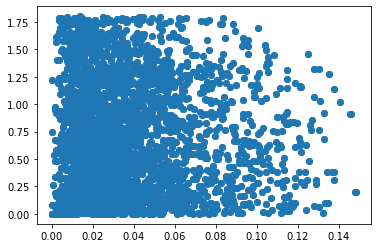

In [15]:
# plot the distances from two lists of TCRs for the same HLA pairs

test_depth_dict_keys = list(depth_dict.keys())

test_depth_values = [depth_dict[x] for x in test_depth_dict_keys]
test_Glazer_values = [Glazer_dict[x] for x in test_depth_dict_keys]

plt.scatter(test_depth_values, test_Glazer_values)
plt.show()

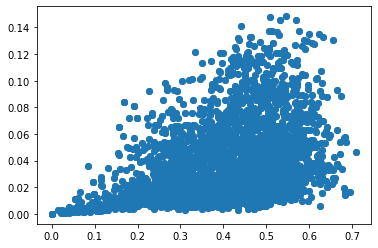

In [21]:
# plot the distances from zheng 2021 positive TCRs and blosum62 for the same HLA pairs
plt.scatter(blosum62_dict.values(), depth_dict.values())
plt.show()

In [22]:
# verify whether each subjects has two alleles for each of A, B, C
# the answer is true

genotype_list = [x.split(",") for x in df_2018_kept.hla_class_i_alleles.tolist()]

ABC_list = []

for genotype in genotype_list:
    ABC_list += ["".join([list(x)[0] for x in genotype])]

Counter(ABC_list)

Counter({'AABBCC': 1443})

In [23]:
genotype_replace_list = [x.split(",") for x in df_2018_kept.hla_class_i_alleles_replace.tolist()]

ABC_replace_list = []

for genotype in genotype_replace_list:
    ABC_replace_list += ["".join([list(x)[0] for x in genotype])]

Counter(ABC_replace_list)

Counter({'AABBCC': 1443})

In [24]:
# compute the distance based on both two TCR resources and pseudo sequence
# based on blosum62 for each subject

# use HLAI_Genotype_replace for depth pos

depth_aa = []
depth_bb = []
depth_cc = []

for genotype in genotype_replace_list:
    depth_aa += [depth_dict[(genotype[0], genotype[1])]]
    depth_bb += [depth_dict[(genotype[2], genotype[3])]]   
    depth_cc += [depth_dict[(genotype[4], genotype[5])]]

depth_ave = [(x+y+z)/3 for x,y,z in zip(depth_aa, depth_bb, depth_cc)]


glazer_aa = []
glazer_bb = []
glazer_cc = []

for genotype in genotype_list:
    glazer_aa += [Glazer_dict[(genotype[0], genotype[1])]]
    glazer_bb += [Glazer_dict[(genotype[2], genotype[3])]]   
    glazer_cc += [Glazer_dict[(genotype[4], genotype[5])]]

glazer_ave = [(x+y+z)/3 for x,y,z in zip(glazer_aa, glazer_bb, glazer_cc)]


# use HLAI_Genotype_replace for aa as well
aa_aa = []
aa_bb = []
aa_cc = []

for genotype in genotype_replace_list:
    aa_aa += [blosum62_dict[(genotype[0], genotype[1])]]
    aa_bb += [blosum62_dict[(genotype[2], genotype[3])]]   
    aa_cc += [blosum62_dict[(genotype[4], genotype[5])]]

aa_ave = [(x+y+z)/3 for x,y,z in zip(aa_aa, aa_bb, aa_cc)]

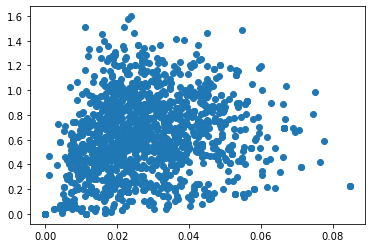

In [25]:
plt.scatter(depth_ave, glazer_ave)
plt.show()

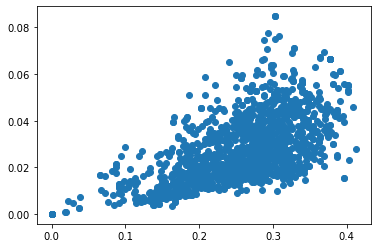

In [26]:
plt.scatter(aa_ave, depth_ave)
plt.show()

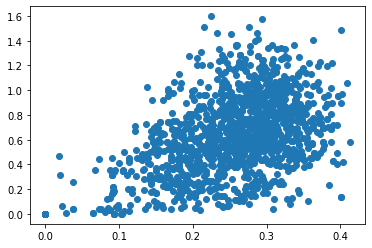

In [27]:
plt.scatter(aa_ave, glazer_ave)
plt.show()

In [28]:
df_2018_kept["depth_ave"] = depth_ave
df_2018_kept["glazer_ave"] = glazer_ave
df_2018_kept["aa_ave"] = aa_ave

In [29]:
min([x for x in df_2018_kept["mutcnt"].tolist() if ((not math.isnan(x)) and (x!=0))])

0.0333333333333333

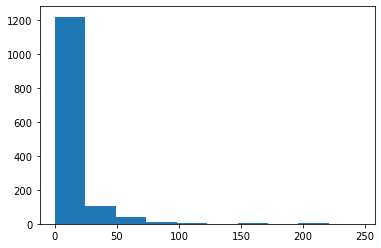

In [30]:
plt.hist(df_2018_kept["mutcnt"])
plt.show()

In [31]:
df_2018_kept["log_mutcnt"] = [math.log10(x+0.01) for x in df_2018_kept["mutcnt"].tolist()]

In [32]:
df_2018_kept.isna().sum()

ID                                0
age                            1086
age_group                         0
os_months                         0
os_event                          0
mutcnt                           58
gender                         1086
drug_class                        0
cancer_type                       2
stage_m                        1099
stage                          1099
reference                         0
hla_class_i_alleles               0
homozygous                        0
hla_class_i_alleles_replace       0
depth_ave                         0
glazer_ave                        0
aa_ave                            0
log_mutcnt                       58
dtype: int64

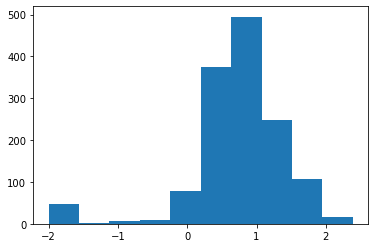

In [33]:
plt.hist(df_2018_kept["log_mutcnt"])
plt.show()

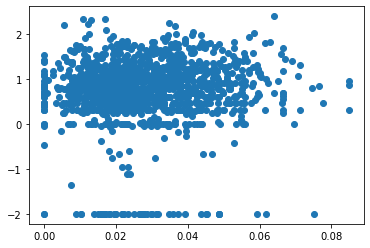

In [34]:
plt.scatter(depth_ave, df_2018_kept["log_mutcnt"])
plt.show()

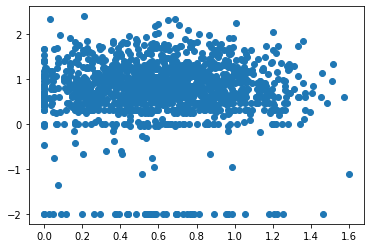

In [35]:
plt.scatter(glazer_ave, df_2018_kept["log_mutcnt"])
plt.show()

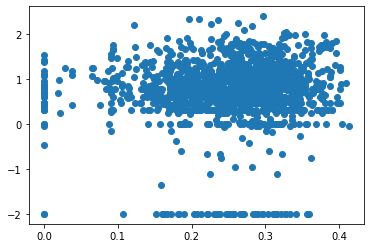

In [36]:
plt.scatter(aa_ave, df_2018_kept["log_mutcnt"])
plt.show()

In [38]:
# save the extended df_2018_kept file out
df_2018_kept.to_csv("../results/st10_chowell_2018_depth_glazer_aa_scores.csv", index = False)

In [ ]:
# compute the ot distance between any two subjects
#   for any two subjects, construct the 6 by 6 matrix
#   compute the ot distance

In [39]:
x_mass = [1/6 for _ in range(6)]
y_mass = [1/6 for _ in range(6)]

In [40]:
depth_ot_mat = []

for genotype_x in genotype_replace_list:
    cur_ot_list = []
    for genotype_y in genotype_replace_list:
        cur_dist_mat = []
        for x0 in genotype_x:
            cur_dist_list = []
            for y0 in genotype_y:
                cur_dist_list += [depth_dict[(x0, y0)]]
            cur_dist_mat += [cur_dist_list]
        cur_ot_list += [ot.emd2(x_mass,y_mass,cur_dist_mat)]
    depth_ot_mat += [cur_ot_list]

In [41]:
glazer_ot_mat = []

for genotype_x in genotype_list:
    cur_ot_list = []
    for genotype_y in genotype_list:
        cur_dist_mat = []
        for x0 in genotype_x:
            cur_dist_list = []
            for y0 in genotype_y:
                cur_dist_list += [Glazer_dict[(x0, y0)]]
            cur_dist_mat += [cur_dist_list]
        cur_ot_list += [ot.emd2(x_mass,y_mass,cur_dist_mat)]
    glazer_ot_mat += [cur_ot_list]

In [42]:
blosum62_ot_mat = []

for genotype_x in genotype_replace_list:
    cur_ot_list = []
    for genotype_y in genotype_replace_list:
        cur_dist_mat = []
        for x0 in genotype_x:
            cur_dist_list = []
            for y0 in genotype_y:
                cur_dist_list += [blosum62_dict[(x0, y0)]]
            cur_dist_mat += [cur_dist_list]
        cur_ot_list += [ot.emd2(x_mass,y_mass,cur_dist_mat)]
    blosum62_ot_mat += [cur_ot_list]

In [43]:
print(len(depth_dict))
print(len(Glazer_dict))
print(len(blosum62_dict))

7225
21316
7225


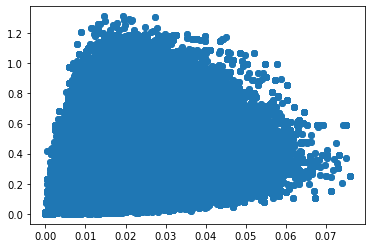

In [44]:
plt.scatter([x for cur in depth_ot_mat for x in cur], 
            [x for cur in glazer_ot_mat for x in cur])
plt.show()

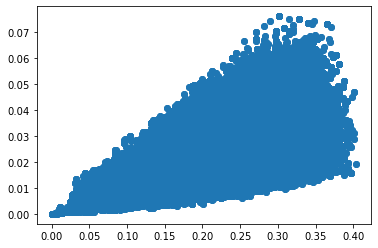

In [45]:
plt.scatter([x for cur in blosum62_ot_mat for x in cur], 
            [x for cur in depth_ot_mat for x in cur])
plt.show()

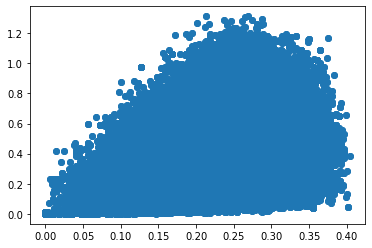

In [46]:
plt.scatter([x for cur in blosum62_ot_mat for x in cur], 
            [x for cur in glazer_ot_mat for x in cur])
plt.show()

In [47]:
df_depth_ot = pd.DataFrame(depth_ot_mat)
df_depth_ot.columns = df_2018_kept['ID'].tolist()

df_glazer_ot = pd.DataFrame(glazer_ot_mat)
df_glazer_ot.columns = df_2018_kept['ID'].tolist()

df_blosum62_ot = pd.DataFrame(blosum62_ot_mat)
df_blosum62_ot.columns = df_2018_kept['ID'].tolist()

In [48]:
df_depth_ot.to_csv("../results/st10_chowell_2018_kept_depth_ot_mat.csv", index = False)
df_glazer_ot.to_csv("../results/st10_chowell_2018_kept_glazer_ot_mat.csv", index = False)
df_blosum62_ot.to_csv("../results/st10_chowell_2018_kept_blosum62_ot_mat.csv", index = False)